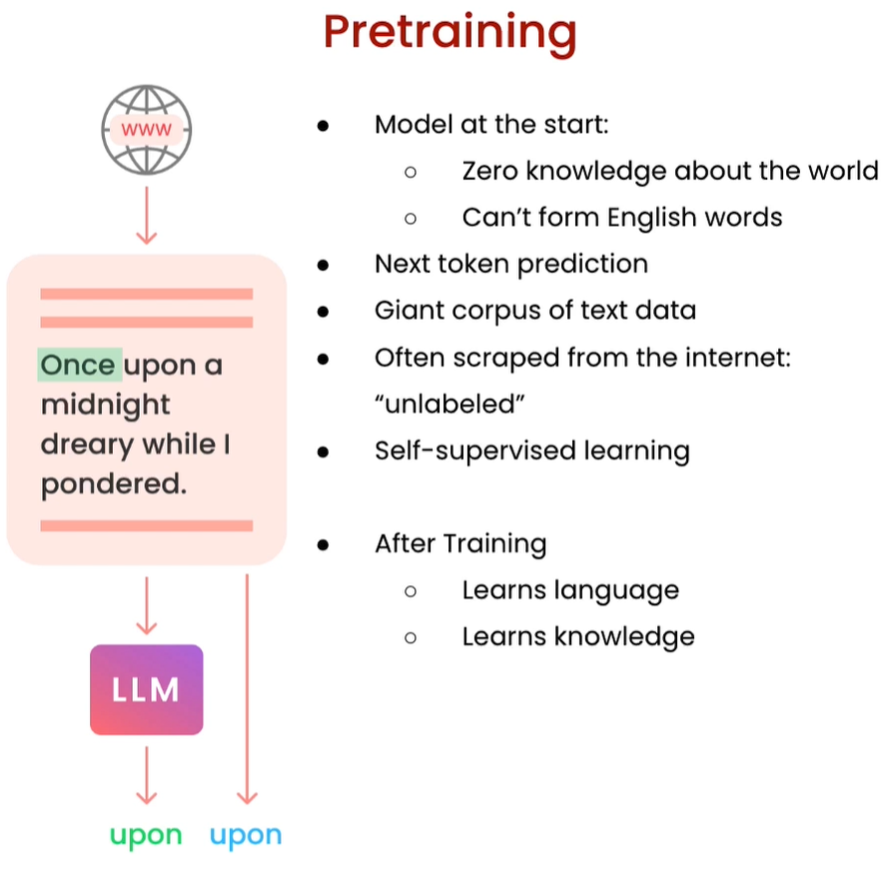

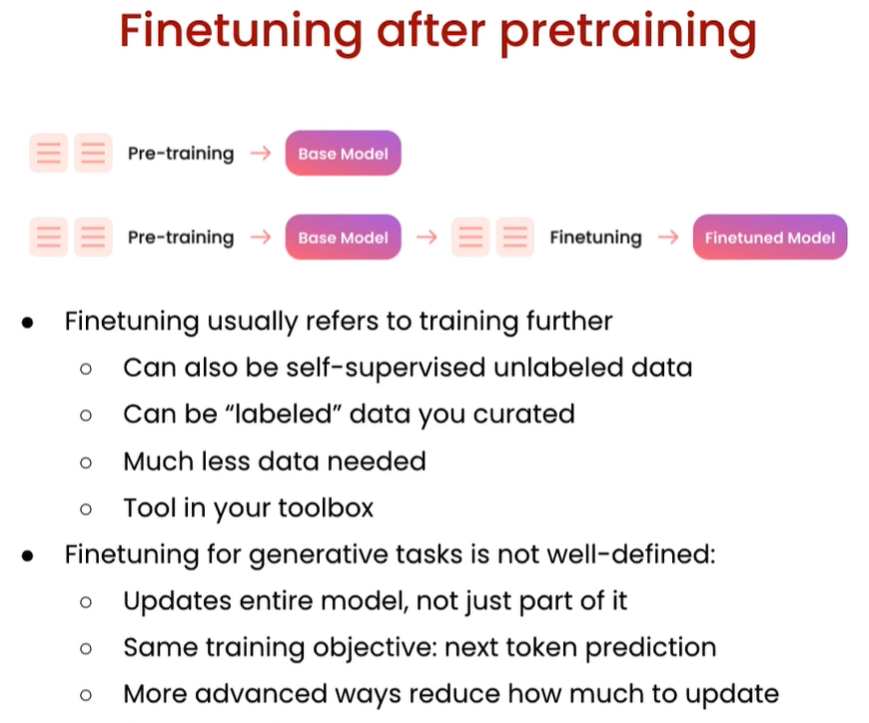

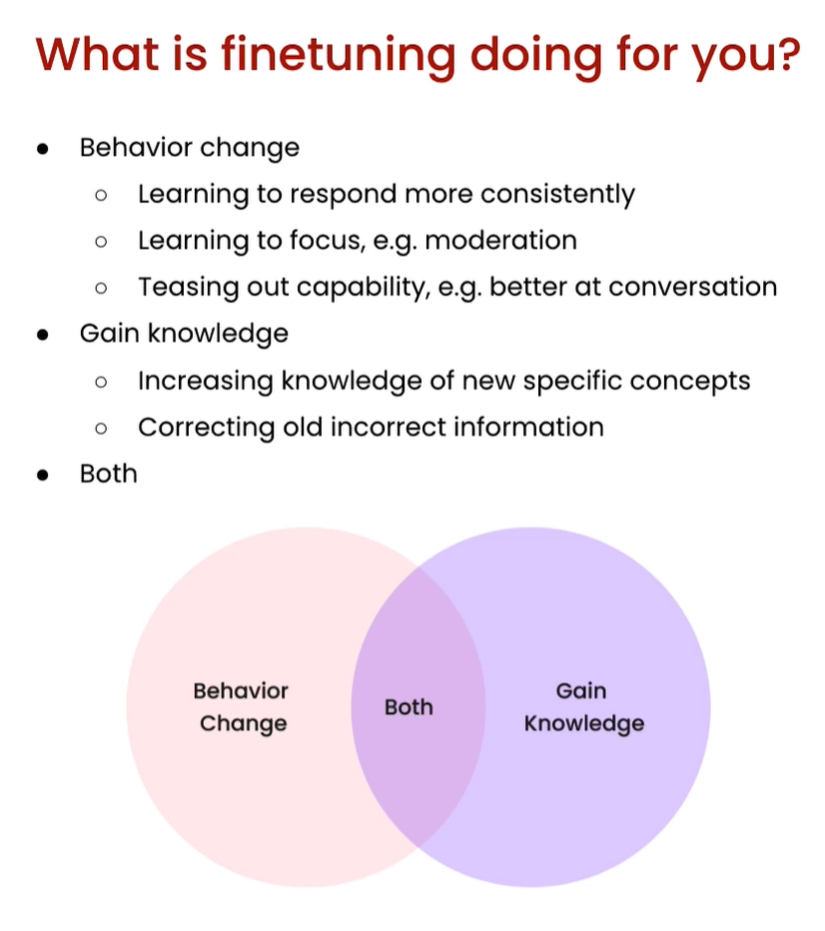

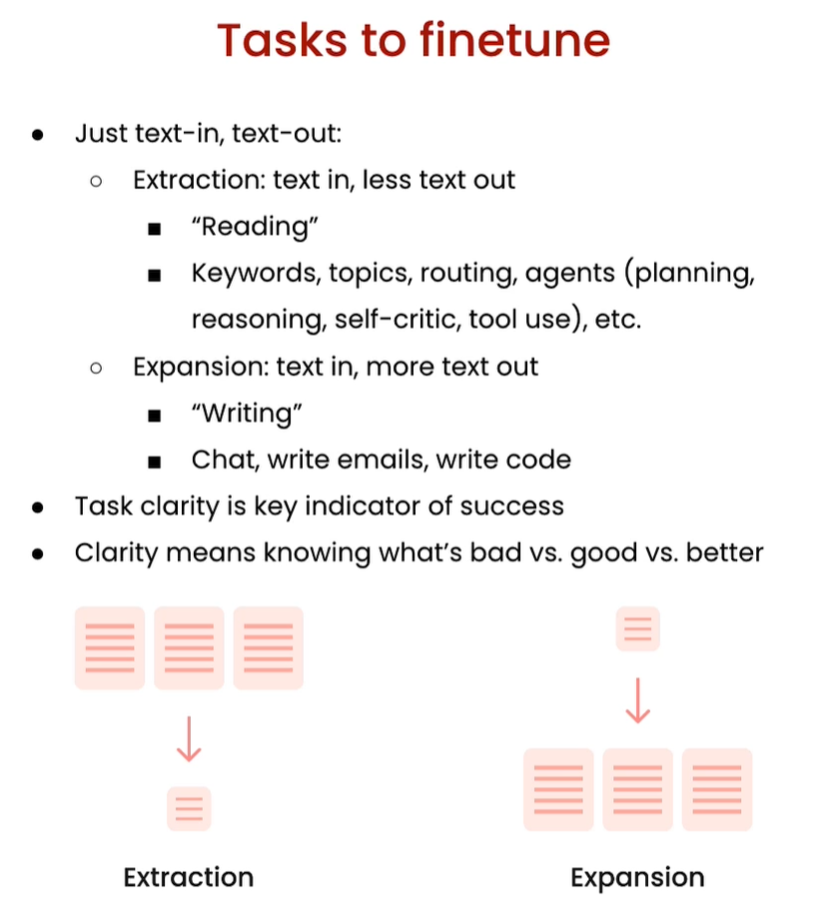

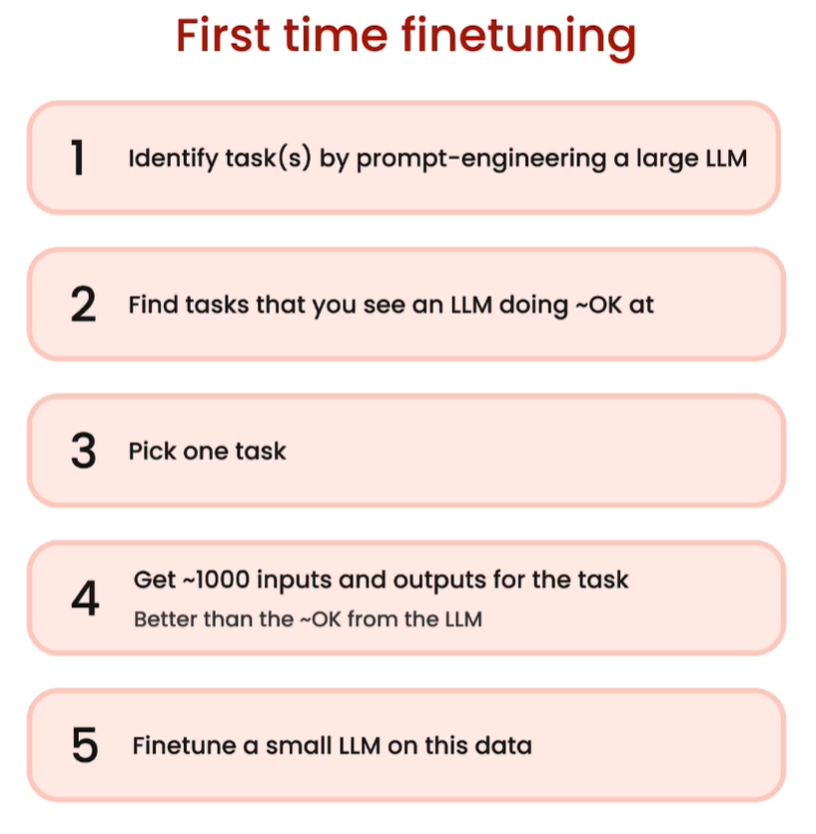

# Finetuning data: compare to pretraining and basic preparation

In [1]:
import jsonlines
import itertools
import pandas as pd
from pprint import pprint

import datasets # From huggingface
from datasets import load_dataset

### Look at pretraining data set

**Sorry**, "The Pile" dataset is currently relocating to a new home and so we can't show you the same example. Here is another dataset, the ["Common Crawl"](https://huggingface.co/datasets/c4) dataset.

In [ ]:
#pretrained_dataset = load_dataset("EleutherAI/pile", split="train", streaming=True)

pretrained_dataset = load_dataset("c4", "en", split="train", streaming=True)


In [ ]:
n = 5
print("Pretrained dataset:")
top_n = itertools.islice(pretrained_dataset, n)
for i in top_n:
  print(i)

### Contrast with company finetuning dataset you will be using

In [6]:
filename = "lamini_docs.jsonl"
instruction_dataset_df = pd.read_json(filename, lines=True)
instruction_dataset_df

,question,answer
0,What are the different types of documents avai...,"Lamini has documentation on Getting Started, A..."
1,What is the recommended way to set up and conf...,Lamini can be downloaded as a python package a...
2,How can I find the specific documentation I ne...,"You can ask this model about documentation, wh..."
3,Does the documentation include explanations of...,Our documentation provides both real-world and...
4,Does the documentation provide information abo...,External dependencies and libraries are all av...
...,...,...
1395,What is Lamini and what is its collaboration w...,Lamini is a library that simplifies the proces...
1396,How does Lamini simplify the process of access...,Lamini simplifies data access in Databricks by...
1397,What are some of the key features provided by ...,Lamini automatically manages the infrastructur...
1398,How does Lamini ensure data privacy during the...,"During the training process, Lamini ensures da..."


### Various ways of formatting your data

In [7]:
examples = instruction_dataset_df.to_dict()
text = examples["question"][0] + examples["answer"][0]
text

"What are the different types of documents available in the repository (e.g., installation guide, API documentation, developer's guide)?Lamini has documentation on Getting Started, Authentication, Question Answer Model, Python Library, Batching, Error Handling, Advanced topics, and class documentation on LLM Engine available at https://lamini-ai.github.io/."

In [8]:
if "question" in examples and "answer" in examples:
  text = examples["question"][0] + examples["answer"][0]
elif "instruction" in examples and "response" in examples:
  text = examples["instruction"][0] + examples["response"][0]
elif "input" in examples and "output" in examples:
  text = examples["input"][0] + examples["output"][0]
else:
  text = examples["text"][0]

In [9]:
prompt_template_qa = """### Question:
{question}

### Answer:
{answer}"""

In [10]:
question = examples["question"][0]
answer = examples["answer"][0]

text_with_prompt_template = prompt_template_qa.format(question=question, answer=answer)
text_with_prompt_template

"### Question:\nWhat are the different types of documents available in the repository (e.g., installation guide, API documentation, developer's guide)?\n\n### Answer:\nLamini has documentation on Getting Started, Authentication, Question Answer Model, Python Library, Batching, Error Handling, Advanced topics, and class documentation on LLM Engine available at https://lamini-ai.github.io/."

In [11]:
prompt_template_q = """### Question:
{question}

### Answer:"""

# Removed {answer} - often it helps to keep the input 
# and output separate. But I'm going to take 
# out {answer} because this helps us using the 
# data set easily for evaluation and for 
# when we split the data set into train and test

In [12]:
num_examples = len(examples["question"])
finetuning_dataset_text_only = []
finetuning_dataset_question_answer = []
for i in range(num_examples):
  question = examples["question"][i]
  answer = examples["answer"][i]

  text_with_prompt_template_qa = prompt_template_qa.format(question=question, answer=answer)
  finetuning_dataset_text_only.append({"text": text_with_prompt_template_qa})

  text_with_prompt_template_q = prompt_template_q.format(question=question)
  finetuning_dataset_question_answer.append({"question": text_with_prompt_template_q, "answer": answer})

In [13]:
pprint(finetuning_dataset_text_only[0])

{'text': '### Question:\n'
         'What are the different types of documents available in the '
         "repository (e.g., installation guide, API documentation, developer's "
         'guide)?\n'
         '\n'
         '### Answer:\n'
         'Lamini has documentation on Getting Started, Authentication, '
         'Question Answer Model, Python Library, Batching, Error Handling, '
         'Advanced topics, and class documentation on LLM Engine available at '
         'https://lamini-ai.github.io/.'}


In [14]:
pprint(finetuning_dataset_question_answer[0])

{'answer': 'Lamini has documentation on Getting Started, Authentication, '
           'Question Answer Model, Python Library, Batching, Error Handling, '
           'Advanced topics, and class documentation on LLM Engine available '
           'at https://lamini-ai.github.io/.',
 'question': '### Question:\n'
             'What are the different types of documents available in the '
             'repository (e.g., installation guide, API documentation, '
             "developer's guide)?\n"
             '\n'
             '### Answer:'}


### Common ways of storing your data

In [15]:
# This is the most common way of storing your data
with jsonlines.open(f'lamini_docs_processed.jsonl', 'w') as writer:
    writer.write_all(finetuning_dataset_question_answer)

In [ ]:
# Can also upload on huggingface then pull up from the cloud
finetuning_dataset_name = "lamini/lamini_docs"
finetuning_dataset = load_dataset(finetuning_dataset_name)
print(finetuning_dataset)